In [22]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from math import sqrt
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [23]:
# Load testing dataset(Daily data)
def read_daily_df(features,file):
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose,loss_function):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,mae,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}, MAE:{}'.format(round(rmse,2),round(mae,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    ax1[0].legend(frameon=False)
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler_y.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[(df['Date']<test_time[0])|(df['Date']>test_time[1])]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    train_y=Scaler_y.fit_transform(train_y.reshape(-1, 1))
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    #y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    MAE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],
                         hyperparameters['verbose'],hyperparameters['loss_function'])
        yhat = Scaler_y.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler_y.inverse_transform(y_test.reshape(-1, 1))
        rmse = mean_squared_error(y_test, yhat,squared=False)
        mae= mean_absolute_error(y_test, yhat)
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        MAE.append(mae)
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],
                     hyperparameters['verbose'],hyperparameters['loss_function'])
    index,X,y = sparse_dataset(test_X,test_y.reshape(-1, 1)) # index is the time series
    yhat = Scaler_y.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = mean_squared_error(y, yhat,squared=False)
    mae = mean_absolute_error(y,yhat)
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test MAE: %.2f' % mae)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler_y.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,mae,r2,nutrient,test_time,ylim)
    return model,RMSE,MAE,R2,figure

In [24]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short:')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])
#all_df=all_df[all_df['Date']>pd.Timestamp(2004,1,1)]

Load training data (containing nutrient observations)
Lake name in short:Mueggelsee
Winter data or not? (Y/N)N


In [25]:
# Create the daily df with Nan in nutrients columns'
print(all_df.info())
n_Nut = int(input('Number of nutrients: (including Chl)'))
Nut_f = ['Date']
for i in range(n_Nut):
    f = input('Nutrients: ')
    Nut_f.append(f)
print(Nut_f)
Nut = all_df[Nut_f]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   426 non-null    datetime64[ns]
 1   thermD                 426 non-null    float64       
 2   delT                   426 non-null    float64       
 3   U                      426 non-null    float64       
 4   AirP                   426 non-null    float64       
 5   Hum                    426 non-null    float64       
 6   AirT                   426 non-null    float64       
 7   SWR                    426 non-null    float64       
 8   CC                     426 non-null    float64       
 9   Prec                   426 non-null    float64       
 10  Ice_d                  426 non-null    float64       
 11  days from iceoff date  426 non-null    float64       
 12  MM                     426 non-null    int64         
 13  MLD  

In [26]:
n_feature = int(input('Number of features used for basic training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

Number of features used for basic training: 13
Feature:delT
Feature:U
Feature:CC
Feature:Prec
Feature:Hum
Feature:AirT
Feature:AirP
Feature:SWR
Feature:Ice_d
Feature:days from iceoff date
Feature:thermD
Feature:MLD
Feature:W
['Date', 'delT', 'U', 'CC', 'Prec', 'Hum', 'AirT', 'AirP', 'SWR', 'Ice_d', 'days from iceoff date', 'thermD', 'MLD', 'W']


In [27]:
# date to seperate training and test sets
YY=all_df['Date'].apply(lambda d:d.year).unique()
print(YY)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),12,31)]

[2004 2005 2006 2008 2009 2010 2011 2012 2013 2014 2016 2017]
test starts in year:2013
test ends in year:2017


In [28]:
# Read daily observation data
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
Daily_df = read_daily_df(features,file) 

In [29]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':100,'dropout':0.03,'time_steps':7,
                   'n_out':1,'verbose':0,
                  'loss_function':'mae'}

In [30]:
# Change to the LSTM folder
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
os.chdir('Scenario2\\LSTM')

In [147]:
features.insert(0,'Date')

In [32]:
features

['delT',
 'U',
 'CC',
 'Prec',
 'Hum',
 'AirT',
 'AirP',
 'SWR',
 'Ice_d',
 'days from iceoff date',
 'thermD',
 'MLD',
 'W',
 'SRP']

Nutrient: SRP
(2168, 8, 13) (2168,) (1093, 8, 13) (1093,)
number of input timesteps: 8
number of features: 13
number of samples: 281
Test RMSE: 65.14
Test MAE: 49.79
Test R2: -2.95
Training dataset RMSE 57.83 (+/- 20.18)
Training dataset MAE 34.97 (+/- 10.25)
Training dataset R2 0.63 (+/- 0.16)
Model takes 6 min to run


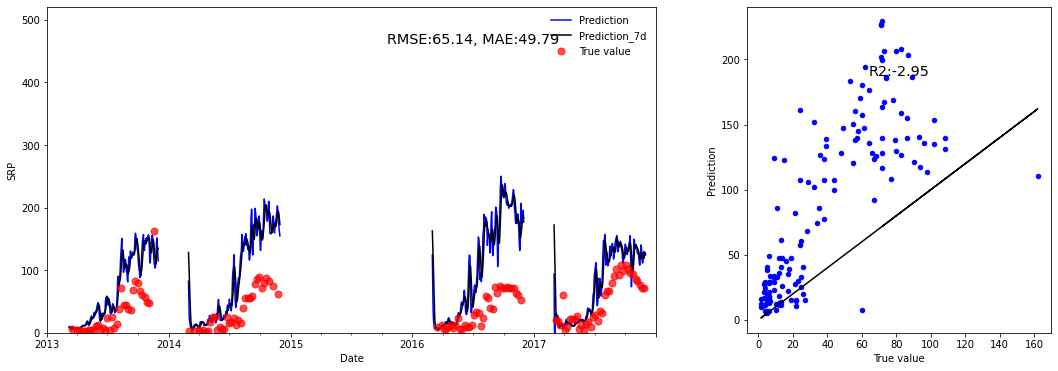

In [31]:
# predict nutreint 1
nutrient = input('Nutrient: ')
# If add the features from process-based model, add features 'MLD','W','thermD'
features.pop(0) # Remove 'Date'
features.append(nutrient)
Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)

Nut_memory = Daily_df.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates('Date'),
                            how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [34]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,CC,Prec,Hum,AirT,AirP,SWR,Ice_d,days from iceoff date,thermD,MLD,W,SRP
0,2004-04-02,-0.048592,8.504962,0.341667,0.000000,36.888056,8.300694,1019.531493,224.925486,56.0,31.0,-5.00,-5.25,0.006834,3.000000
1,2004-04-03,-0.003405,3.983062,0.537500,0.045833,54.560174,8.975451,1019.385764,227.798611,56.0,32.0,-0.25,-5.25,0.000566,3.000000
2,2004-04-04,-0.002254,3.498938,0.635417,0.095833,72.037674,9.247326,1016.652431,230.662431,56.0,33.0,-0.25,-5.25,0.003277,3.000000
3,2004-04-05,-0.003688,3.768487,0.677083,0.012500,69.833472,7.908889,1009.647292,233.515799,56.0,34.0,-0.25,-5.25,0.002457,3.000000
4,2004-04-06,-0.003325,4.629075,0.718750,0.116667,78.243194,5.575278,1000.206493,236.353993,56.0,35.0,-0.25,-5.25,0.001421,13.345950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2017-11-26,-0.002033,5.565000,0.725000,0.004167,88.880382,3.350764,1017.154896,51.242604,43.0,278.0,-0.25,-5.25,0.000213,130.029114
3264,2017-11-27,-0.001021,7.061700,0.854167,0.145833,85.793090,4.122014,1014.892604,50.292569,43.0,279.0,-0.25,-5.25,0.000099,128.322983
3265,2017-11-28,-0.000307,6.045000,0.937500,0.020833,81.312500,5.732604,1004.273403,49.397778,43.0,280.0,-0.25,-5.25,0.000000,127.395966
3266,2017-11-29,-0.001267,2.366813,0.679167,0.000000,81.588750,3.184028,1005.741771,48.541493,43.0,281.0,-0.25,-5.25,0.000113,127.251648


Nutrient: TotP
['delT', 'U', 'CC', 'Prec', 'Hum', 'AirT', 'AirP', 'SWR', 'Ice_d', 'days from iceoff date', 'thermD', 'MLD', 'W', 'SRP']
Delete features? (Y/N)N
Add features? (Y/N)N
(2168, 8, 14) (2168,) (1093, 8, 14) (1093,)
number of input timesteps: 8
number of features: 14
number of samples: 281
Test RMSE: 75.19
Test MAE: 61.25
Test R2: -3.66
Training dataset RMSE 52.99 (+/- 11.36)
Training dataset MAE 37.50 (+/- 7.85)
Training dataset R2 0.76 (+/- 0.06)
Model takes 5 min to run


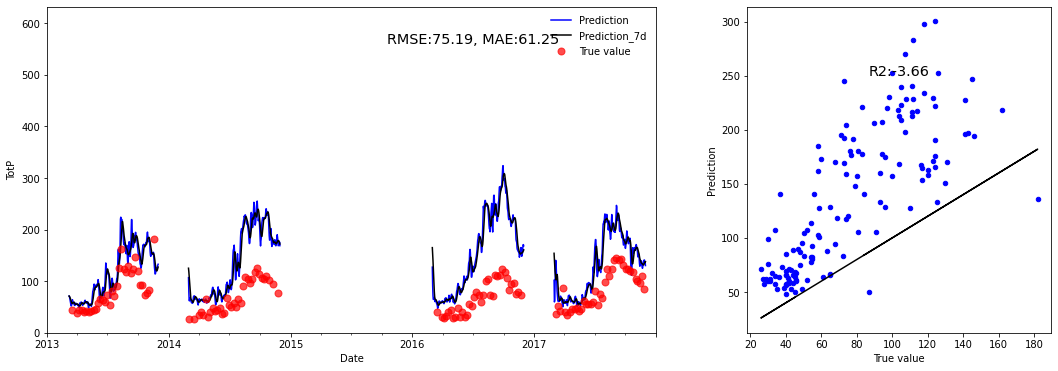

In [35]:
# predict nutreint 2
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
features.append(nutrient)

Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)

Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates('Date')
                              ,how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [36]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,CC,Prec,Hum,AirT,AirP,SWR,Ice_d,days from iceoff date,thermD,MLD,W,SRP,TotP
0,2004-04-02,-0.048592,8.504962,0.341667,0.000000,36.888056,8.300694,1019.531493,224.925486,56.0,31.0,-5.00,-5.25,0.006834,3.000000,76.000000
1,2004-04-03,-0.003405,3.983062,0.537500,0.045833,54.560174,8.975451,1019.385764,227.798611,56.0,32.0,-0.25,-5.25,0.000566,3.000000,76.000000
2,2004-04-04,-0.002254,3.498938,0.635417,0.095833,72.037674,9.247326,1016.652431,230.662431,56.0,33.0,-0.25,-5.25,0.003277,3.000000,76.000000
3,2004-04-05,-0.003688,3.768487,0.677083,0.012500,69.833472,7.908889,1009.647292,233.515799,56.0,34.0,-0.25,-5.25,0.002457,3.000000,76.000000
4,2004-04-06,-0.003325,4.629075,0.718750,0.116667,78.243194,5.575278,1000.206493,236.353993,56.0,35.0,-0.25,-5.25,0.001421,13.345950,65.261383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2017-11-26,-0.002033,5.565000,0.725000,0.004167,88.880382,3.350764,1017.154896,51.242604,43.0,278.0,-0.25,-5.25,0.000213,130.029114,141.102493
3264,2017-11-27,-0.001021,7.061700,0.854167,0.145833,85.793090,4.122014,1014.892604,50.292569,43.0,279.0,-0.25,-5.25,0.000099,128.322983,140.935287
3265,2017-11-28,-0.000307,6.045000,0.937500,0.020833,81.312500,5.732604,1004.273403,49.397778,43.0,280.0,-0.25,-5.25,0.000000,127.395966,137.595032
3266,2017-11-29,-0.001267,2.366813,0.679167,0.000000,81.588750,3.184028,1005.741771,48.541493,43.0,281.0,-0.25,-5.25,0.000113,127.251648,136.451797


Nutrient: NO3
['delT', 'U', 'CC', 'Prec', 'Hum', 'AirT', 'AirP', 'SWR', 'Ice_d', 'days from iceoff date', 'thermD', 'MLD', 'W', 'SRP', 'TotP']
Delete features? (Y/N)n
Add features? (Y/N)n
(2168, 8, 15) (2168,) (1093, 8, 15) (1093,)
number of input timesteps: 8
number of features: 15
number of samples: 280
Test RMSE: 0.22
Test MAE: 0.15
Test R2: 0.30
Training dataset RMSE 0.19 (+/- 0.03)
Training dataset MAE 0.11 (+/- 0.03)
Training dataset R2 0.54 (+/- 0.13)
Model takes 5 min to run


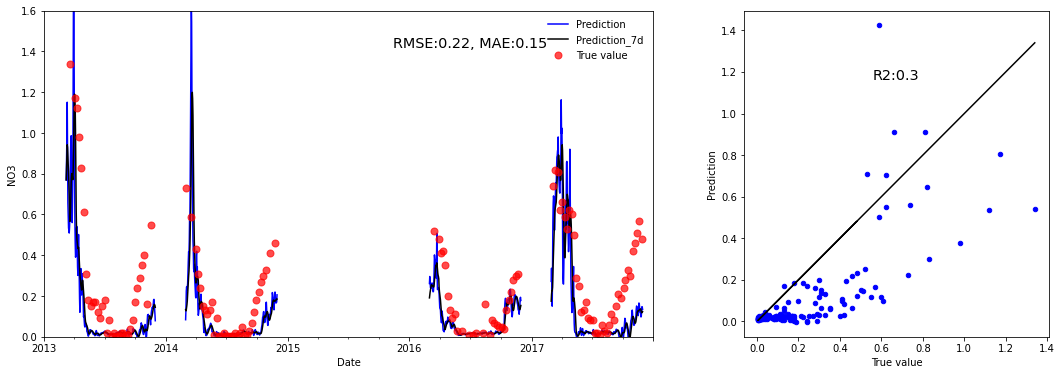

In [37]:
# predict nutreint 3
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)

Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)

Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [38]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,CC,Prec,Hum,AirT,AirP,SWR,Ice_d,days from iceoff date,thermD,MLD,W,SRP,TotP,NO3
0,2004-04-02,-0.048592,8.504962,0.341667,0.000000,36.888056,8.300694,1019.531493,224.925486,56.0,31.0,-5.00,-5.25,0.006834,3.000000,76.000000,0.000000
1,2004-04-03,-0.003405,3.983062,0.537500,0.045833,54.560174,8.975451,1019.385764,227.798611,56.0,32.0,-0.25,-5.25,0.000566,3.000000,76.000000,0.000000
2,2004-04-04,-0.002254,3.498938,0.635417,0.095833,72.037674,9.247326,1016.652431,230.662431,56.0,33.0,-0.25,-5.25,0.003277,3.000000,76.000000,0.000000
3,2004-04-05,-0.003688,3.768487,0.677083,0.012500,69.833472,7.908889,1009.647292,233.515799,56.0,34.0,-0.25,-5.25,0.002457,3.000000,76.000000,0.000000
4,2004-04-06,-0.003325,4.629075,0.718750,0.116667,78.243194,5.575278,1000.206493,236.353993,56.0,35.0,-0.25,-5.25,0.001421,13.345950,65.261383,1.023965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2017-11-26,-0.002033,5.565000,0.725000,0.004167,88.880382,3.350764,1017.154896,51.242604,43.0,278.0,-0.25,-5.25,0.000213,130.029114,141.102493,0.098528
3264,2017-11-27,-0.001021,7.061700,0.854167,0.145833,85.793090,4.122014,1014.892604,50.292569,43.0,279.0,-0.25,-5.25,0.000099,128.322983,140.935287,0.122281
3265,2017-11-28,-0.000307,6.045000,0.937500,0.020833,81.312500,5.732604,1004.273403,49.397778,43.0,280.0,-0.25,-5.25,0.000000,127.395966,137.595032,0.147944
3266,2017-11-29,-0.001267,2.366813,0.679167,0.000000,81.588750,3.184028,1005.741771,48.541493,43.0,281.0,-0.25,-5.25,0.000113,127.251648,136.451797,0.145552


Nutrient: NH4
['delT', 'U', 'CC', 'Prec', 'Hum', 'AirT', 'AirP', 'SWR', 'Ice_d', 'days from iceoff date', 'thermD', 'MLD', 'W', 'SRP', 'TotP', 'NO3']
Delete features? (Y/N)n
Add features? (Y/N)n
(2168, 8, 16) (2168,) (1093, 8, 16) (1093,)
number of input timesteps: 8
number of features: 16
number of samples: 281
Test RMSE: 0.07
Test MAE: 0.04
Test R2: -0.14
Training dataset RMSE 0.09 (+/- 0.02)
Training dataset MAE 0.06 (+/- 0.01)
Training dataset R2 0.11 (+/- 0.33)
Model takes 5 min to run


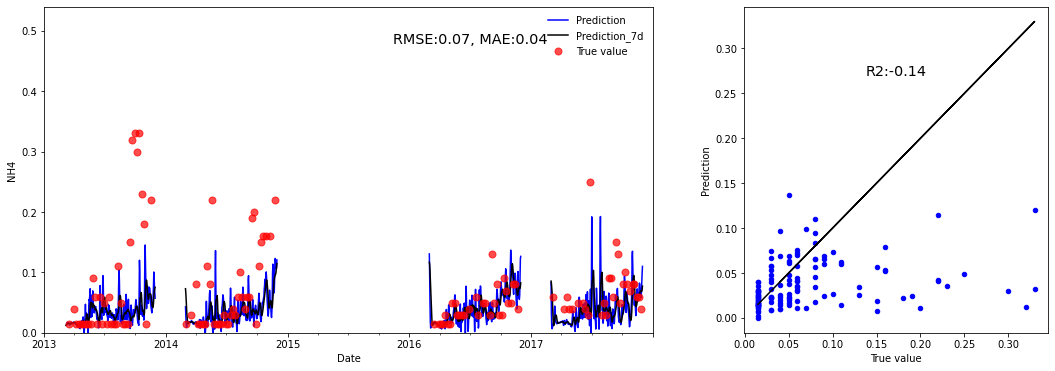

In [39]:
# predict nutreint 4
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)

Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)

Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [40]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,CC,Prec,Hum,AirT,AirP,SWR,Ice_d,days from iceoff date,thermD,MLD,W,SRP,TotP,NO3,NH4
0,2004-04-02,-0.048592,8.504962,0.341667,0.000000,36.888056,8.300694,1019.531493,224.925486,56.0,31.0,-5.00,-5.25,0.006834,3.000000,76.000000,0.000000,0.010000
1,2004-04-03,-0.003405,3.983062,0.537500,0.045833,54.560174,8.975451,1019.385764,227.798611,56.0,32.0,-0.25,-5.25,0.000566,3.000000,76.000000,0.000000,0.010000
2,2004-04-04,-0.002254,3.498938,0.635417,0.095833,72.037674,9.247326,1016.652431,230.662431,56.0,33.0,-0.25,-5.25,0.003277,3.000000,76.000000,0.000000,0.010000
3,2004-04-05,-0.003688,3.768487,0.677083,0.012500,69.833472,7.908889,1009.647292,233.515799,56.0,34.0,-0.25,-5.25,0.002457,3.000000,76.000000,0.000000,0.010000
4,2004-04-06,-0.003325,4.629075,0.718750,0.116667,78.243194,5.575278,1000.206493,236.353993,56.0,35.0,-0.25,-5.25,0.001421,13.345950,65.261383,1.023965,0.023374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2017-11-26,-0.002033,5.565000,0.725000,0.004167,88.880382,3.350764,1017.154896,51.242604,43.0,278.0,-0.25,-5.25,0.000213,130.029114,141.102493,0.098528,0.058052
3264,2017-11-27,-0.001021,7.061700,0.854167,0.145833,85.793090,4.122014,1014.892604,50.292569,43.0,279.0,-0.25,-5.25,0.000099,128.322983,140.935287,0.122281,0.069120
3265,2017-11-28,-0.000307,6.045000,0.937500,0.020833,81.312500,5.732604,1004.273403,49.397778,43.0,280.0,-0.25,-5.25,0.000000,127.395966,137.595032,0.147944,0.085534
3266,2017-11-29,-0.001267,2.366813,0.679167,0.000000,81.588750,3.184028,1005.741771,48.541493,43.0,281.0,-0.25,-5.25,0.000113,127.251648,136.451797,0.145552,0.098301


Nutrient: Si
['delT', 'U', 'CC', 'Prec', 'Hum', 'AirT', 'AirP', 'SWR', 'Ice_d', 'days from iceoff date', 'thermD', 'MLD', 'W', 'SRP', 'TotP', 'NO3', 'NH4']
Delete features? (Y/N)N
Add features? (Y/N)N
(2168, 8, 17) (2168,) (1093, 8, 17) (1093,)
number of input timesteps: 8
number of features: 17
number of samples: 279
Test RMSE: 2.81
Test MAE: 2.25
Test R2: -3.65
Training dataset RMSE 2.17 (+/- 0.36)
Training dataset MAE 1.62 (+/- 0.28)
Training dataset R2 0.28 (+/- 0.19)
Model takes 6 min to run


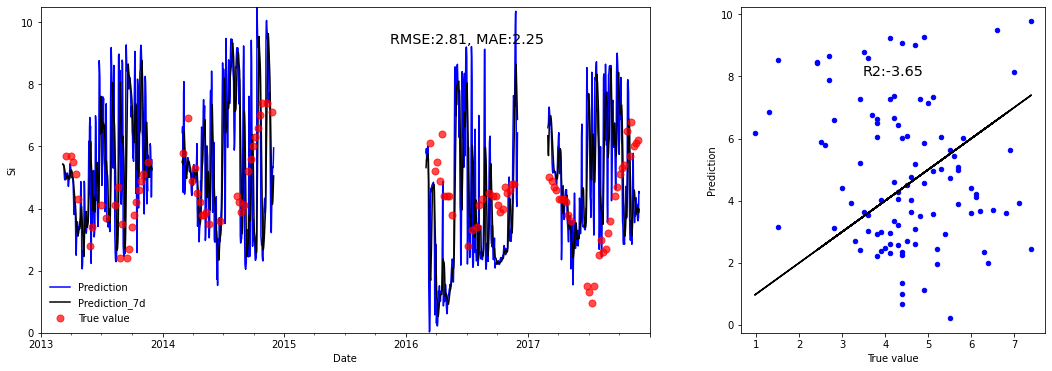

In [41]:
# predict nutreint 5
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)

Scaler_X = MinMaxScaler()
Scaler_y = PowerTransformer(standardize=False)

Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [42]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,CC,Prec,Hum,AirT,AirP,SWR,Ice_d,days from iceoff date,thermD,MLD,W,SRP,TotP,NO3,NH4,Si
0,2004-04-02,-0.048592,8.504962,0.341667,0.000000,36.888056,8.300694,1019.531493,224.925486,56.0,31.0,-5.00,-5.25,0.006834,3.000000,76.000000,0.000000,0.010000,2.100000
1,2004-04-03,-0.003405,3.983062,0.537500,0.045833,54.560174,8.975451,1019.385764,227.798611,56.0,32.0,-0.25,-5.25,0.000566,3.000000,76.000000,0.000000,0.010000,2.100000
2,2004-04-04,-0.002254,3.498938,0.635417,0.095833,72.037674,9.247326,1016.652431,230.662431,56.0,33.0,-0.25,-5.25,0.003277,3.000000,76.000000,0.000000,0.010000,2.100000
3,2004-04-05,-0.003688,3.768487,0.677083,0.012500,69.833472,7.908889,1009.647292,233.515799,56.0,34.0,-0.25,-5.25,0.002457,3.000000,76.000000,0.000000,0.010000,2.100000
4,2004-04-06,-0.003325,4.629075,0.718750,0.116667,78.243194,5.575278,1000.206493,236.353993,56.0,35.0,-0.25,-5.25,0.001421,13.345950,65.261383,1.023965,0.023374,3.418213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2017-11-26,-0.002033,5.565000,0.725000,0.004167,88.880382,3.350764,1017.154896,51.242604,43.0,278.0,-0.25,-5.25,0.000213,130.029114,141.102493,0.098528,0.058052,3.602902
3264,2017-11-27,-0.001021,7.061700,0.854167,0.145833,85.793090,4.122014,1014.892604,50.292569,43.0,279.0,-0.25,-5.25,0.000099,128.322983,140.935287,0.122281,0.069120,3.674663
3265,2017-11-28,-0.000307,6.045000,0.937500,0.020833,81.312500,5.732604,1004.273403,49.397778,43.0,280.0,-0.25,-5.25,0.000000,127.395966,137.595032,0.147944,0.085534,3.698538
3266,2017-11-29,-0.001267,2.366813,0.679167,0.000000,81.588750,3.184028,1005.741771,48.541493,43.0,281.0,-0.25,-5.25,0.000113,127.251648,136.451797,0.145552,0.098301,4.552844


Nutrient: Si
['delT', 'U', 'CC', 'Prec', 'SWR', 'AirT', 'Humidity', 'inflow', 'outflow', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'NOX', 'O2', 'PO4', 'TotP', 'NH4']
Delete features? (Y/N)N
Add features? (Y/N)N
(3937, 8, 19) (3937,) (1206, 8, 19) (1206,)
number of input timesteps: 8
number of features: 19
number of samples: 432
Test RMSE: 25.52
Test MAE: 19.43
Test R2: -0.96
Training dataset RMSE 19.90 (+/- 1.52)
Training dataset MAE 15.91 (+/- 1.09)
Training dataset R2 0.18 (+/- 0.08)
Model takes 19 min to run


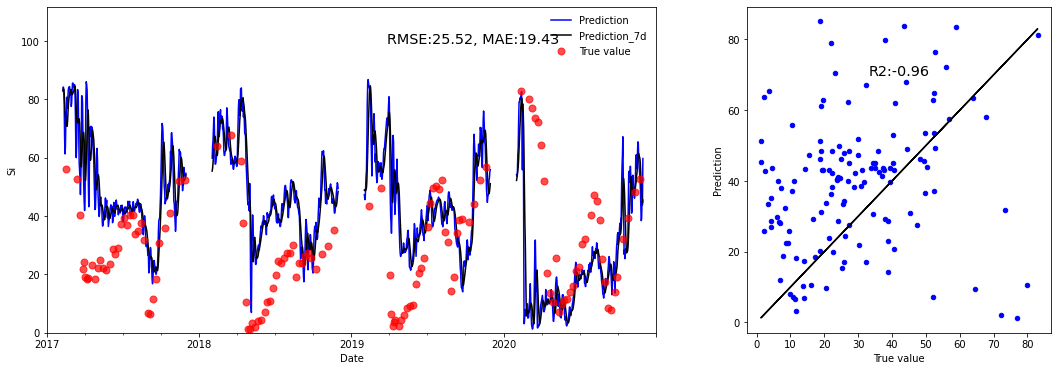

In [181]:
# predict nutreint 6
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)

Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)

Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [182]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,CC,Prec,SWR,AirT,Humidity,inflow,outflow,Ice_d,days from iceoff,W,MLD,thermD,NOX,O2,PO4,TotP,NH4,Si
0,2004-02-01,-0.064141,3.671083,0.720833,0.0,132.30,-3.393750,85.312500,1.491,-1.840,106.0,-73.0,0.010411,-21.0,-20.75,6.977051,418.139191,0.994538,1.383484,0.308057,66.998802
1,2004-02-02,-0.064310,1.969792,0.570833,0.2,342.80,-4.919167,87.583333,1.530,-1.818,106.0,-72.0,0.019445,-21.0,-20.75,6.977051,418.139191,0.994538,1.383484,0.308057,66.998802
2,2004-02-03,-0.052165,3.992833,1.000000,2.2,97.40,1.658750,91.458333,1.568,-1.795,106.0,-71.0,0.069768,-21.0,-20.75,6.977051,418.139191,0.994538,1.383484,0.308057,66.998802
3,2004-02-04,-0.064363,9.979750,0.633333,0.0,255.50,5.242500,84.541667,1.597,-1.774,106.0,-70.0,0.014868,-21.0,-20.75,6.977051,418.139191,0.994538,1.383484,0.308057,66.998802
4,2004-02-05,-0.061452,4.696917,0.570833,0.0,344.60,2.404583,82.666667,1.685,-1.753,106.0,-69.0,0.001870,-21.0,-20.75,6.977051,418.139191,0.994538,1.383484,0.308057,66.998802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,2020-11-26,0.111327,3.321292,0.845833,0.0,31.39,5.930417,98.125000,0.779,-0.465,5.0,291.0,0.002728,-21.0,-20.75,3.754610,368.027832,0.830137,1.250412,0.604626,38.435558
5146,2020-11-27,0.063770,4.360500,0.945833,0.4,57.70,2.672083,92.695833,0.781,-0.450,5.0,292.0,0.014944,-21.0,-20.75,3.751565,362.511688,0.827321,1.246894,0.417090,39.099693
5147,2020-11-28,-0.006724,2.387167,1.000000,0.2,52.75,1.992500,92.887500,0.773,-0.437,5.0,293.0,0.002919,-21.0,-20.75,3.732522,358.755249,0.814598,1.243505,0.305958,45.009972
5148,2020-11-29,-0.023648,2.114958,1.000000,0.7,32.69,0.251667,99.500000,0.789,-0.424,5.0,294.0,0.028674,-21.0,-20.75,3.771983,354.669769,0.798573,1.239482,0.306820,43.850082


Nutrient: SiO2
['delT', 'U', 'CC', 'Prec', 'AirP', 'AirT', 'RelHum', 'SWR', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'NO3N', 'O2', 'PO4P', 'TOTP', 'NH4N', 'TOTN']
Delete features? (Y/N)N
Add features? (Y/N)N
(4950, 8, 21) (4950,) (1093, 8, 21) (1093,)
number of input timesteps: 8
number of features: 21
number of samples: 167
Test RMSE: 1.12
Test R2: 0.46
Training dataset RMSE 0.65 (+/- 0.13)
Training dataset R2 0.70 (+/- 0.09)
Model takes 4 min to run


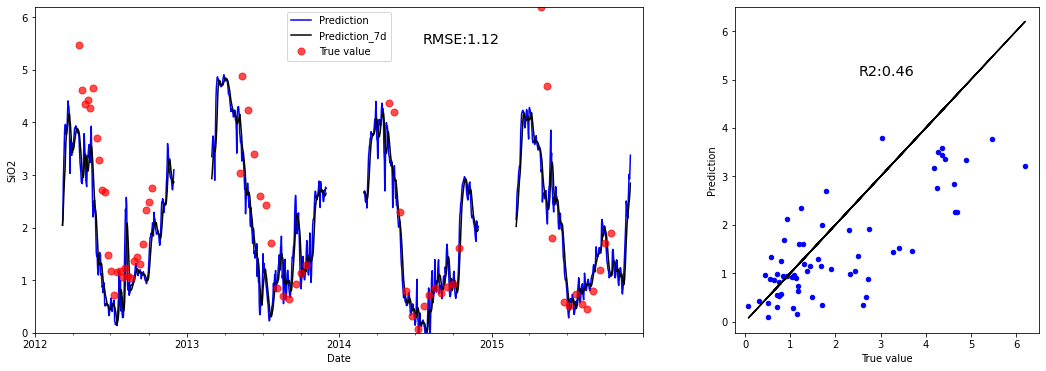

In [31]:
# predict nutreint 7
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Scaler_X = MinMaxScaler()
Scaler_y = PowerTransformer(standardize=False)

Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [32]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,CC,Prec,AirP,AirT,RelHum,SWR,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,NO3N,O2,PO4P,TOTP,NH4N,TOTN,SiO2
0,1994-03-01,0.256206,3.483176,0.458692,0.830272,1018.4190,-9.955431,70.289411,55.50429,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,1074.167236,13.928143,14.681718,30.488056,-1.937988,1219.252441,4.467033
1,1994-03-02,0.256183,3.226721,0.854867,1.530000,1012.0800,-8.835930,81.223724,54.56624,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,1074.167236,13.928143,14.681718,30.488056,-1.937988,1219.252441,4.467033
2,1994-03-03,0.256237,1.846146,0.993754,0.423039,1002.8600,-4.911451,88.727730,107.72920,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,1074.167236,13.928143,14.681718,30.488056,-1.937988,1219.252441,4.467033
3,1994-03-04,0.256201,0.842008,0.708459,0.000784,1005.3750,-2.776745,91.194580,134.25160,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,1074.167236,13.928143,14.681718,30.488056,-1.937988,1219.252441,4.467033
4,1994-03-05,0.256180,7.107113,1.000008,0.338688,997.0792,2.236131,92.617668,80.39046,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,1074.167236,13.928143,14.681718,30.488056,-1.937988,1219.252441,4.467033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,2.130598,2.173018,0.548573,0.000000,994.5456,0.139770,93.686831,20.64251,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,372.134613,9.575217,8.535047,30.743734,13.483063,1009.688721,2.786333
6046,2015-11-27,1.606879,6.680271,0.968004,0.001345,985.3168,9.021081,90.547242,21.62850,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,341.119904,9.669332,8.670540,28.353182,16.187761,1005.430542,3.012413
6047,2015-11-28,0.004524,4.535557,0.634158,0.003703,978.9278,4.759586,86.624472,21.59980,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,319.257751,9.486859,9.565480,28.095707,24.589928,999.542908,2.923663
6048,2015-11-29,0.003058,4.846388,0.928686,0.000335,969.5997,3.935289,87.554448,20.77313,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,341.167358,9.000576,8.833440,28.171436,26.986954,991.856201,3.094386


Nutrient: SiO2
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN', 'TOC']
Delete features? (Y/N)N
Add features? (Y/N)N
(4950, 8, 22) (4950,) (1093, 8, 22) (1093,)
number of input timesteps: 8
number of features: 22
number of samples: 167
Test RMSE: 1.15
Test R2: 0.43
Training dataset RMSE 0.83 (+/- 0.18)
Training dataset R2 0.51 (+/- 0.15)
Model takes 4 min to run


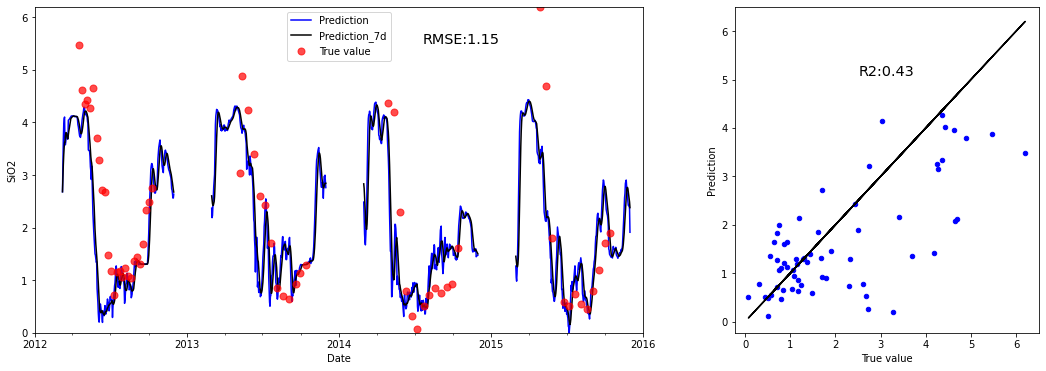

In [34]:
# predict nutreint 8
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Scaler_X = MinMaxScaler()
Scaler_y = PowerTransformer(standardize=False)

Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [35]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,CC,Prec,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,O2,NO3N,NH4N,PO4P,TOTP,TOTN,TOC,SiO2
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.458692,0.830272,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,0.854867,1.530000,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.993754,0.423039,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.708459,0.000784,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,1.000008,0.338688,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.548573,0.000000,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,8.872602,55.972729,15.604255,8.623958,31.749716,784.934448,8.587276,2.421144
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.968004,0.001345,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,8.792369,16.538393,19.361982,7.025309,29.891218,702.546997,7.742613,2.417079
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.634158,0.003703,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,8.806619,158.694748,22.888605,6.790660,29.994944,729.221436,7.682547,2.430667
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.928686,0.000335,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,8.846630,190.166748,22.555815,6.788723,28.392122,764.089233,7.832428,2.352034


In [40]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':100,'dropout':0.01,'time_steps':7,
                   'n_out':1,'verbose':0,
                  'loss_function':'mae'}

In [190]:
Nut_memory.drop('Chl',axis=1,inplace=True)

Nutrient: Chl
['delT', 'U', 'CC', 'Prec', 'Hum', 'AirT', 'AirP', 'SWR', 'Ice_d', 'days from iceoff date', 'thermD', 'MLD', 'W', 'SRP', 'TotP', 'NO3', 'NH4', 'Si']
Delete features? (Y/N)N
Add features? (Y/N)N
(2168, 8, 18) (2168,) (1093, 8, 18) (1093,)
number of input timesteps: 8
number of features: 18
number of samples: 280
Test RMSE: 18.49
Test MAE: 15.15
Test R2: -1.31
Training dataset RMSE 22.13 (+/- 3.01)
Training dataset MAE 16.40 (+/- 1.80)
Training dataset R2 0.00 (+/- 0.25)
Model takes 5 min to run


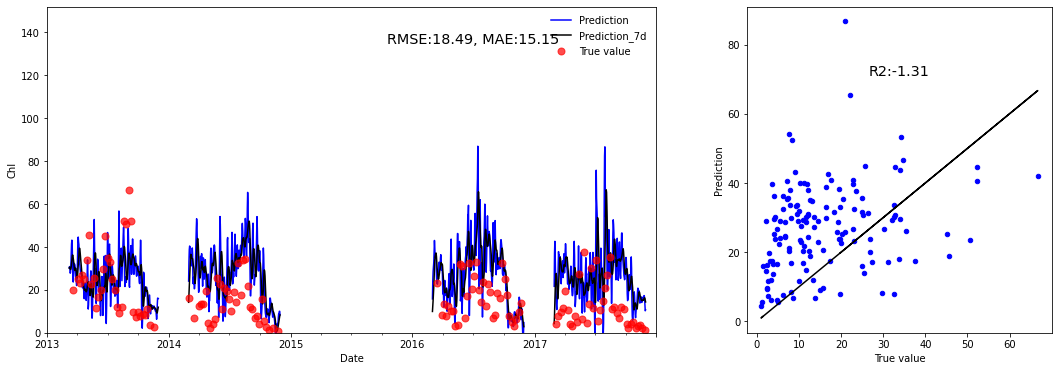

In [43]:
# predict Chl
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
features.append(nutrient)

Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)

Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),columns=reframed.columns[:-1])
#target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
#                 name=reframed.columns[-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,MAE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [120]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,delT,U,CC,SWR,Prec,Hum,AirT,AirP,Ice_d,days from iceoff date,thermD,W,MLD,NO3,SRP,TotP,NH4,Si,Chl
0,2004-04-02,-0.048592,8.504962,0.341667,224.925486,0.000000,36.888056,8.300694,1019.531493,56.0,31.0,-5.00,0.006834,-5.25,0.000000,3.000000,76.000000,0.010000,2.100000,27.000000
1,2004-04-03,-0.003405,3.983062,0.537500,227.798611,0.045833,54.560174,8.975451,1019.385764,56.0,32.0,-0.25,0.000566,-5.25,0.000000,3.000000,76.000000,0.010000,2.100000,27.000000
2,2004-04-04,-0.002254,3.498938,0.635417,230.662431,0.095833,72.037674,9.247326,1016.652431,56.0,33.0,-0.25,0.003277,-5.25,0.000000,3.000000,76.000000,0.010000,2.100000,27.000000
3,2004-04-05,-0.003688,3.768487,0.677083,233.515799,0.012500,69.833472,7.908889,1009.647292,56.0,34.0,-0.25,0.002457,-5.25,0.000000,3.000000,76.000000,0.010000,2.100000,27.000000
4,2004-04-06,-0.003325,4.629075,0.718750,236.353993,0.116667,78.243194,5.575278,1000.206493,56.0,35.0,-0.25,0.001421,-5.25,0.945573,13.470508,60.053391,0.026111,2.981093,28.106808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263,2017-11-26,-0.002033,5.565000,0.725000,51.242604,0.004167,88.880382,3.350764,1017.154896,43.0,278.0,-0.25,0.000213,-5.25,0.084618,104.673920,121.857803,0.033011,4.552163,10.658734
3264,2017-11-27,-0.001021,7.061700,0.854167,50.292569,0.145833,85.793090,4.122014,1014.892604,43.0,279.0,-0.25,0.000099,-5.25,0.096385,109.342934,123.224182,0.055464,4.682192,10.376298
3265,2017-11-28,-0.000307,6.045000,0.937500,49.397778,0.020833,81.312500,5.732604,1004.273403,43.0,280.0,-0.25,0.000000,-5.25,0.106955,112.600098,122.330605,0.074072,4.155821,9.952971
3266,2017-11-29,-0.001267,2.366813,0.679167,48.541493,0.000000,81.588750,3.184028,1005.741771,43.0,281.0,-0.25,0.000113,-5.25,0.092408,112.146019,122.125519,0.081984,4.357455,8.305986


In [121]:
Nut_memory.to_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep='\t',index = False)

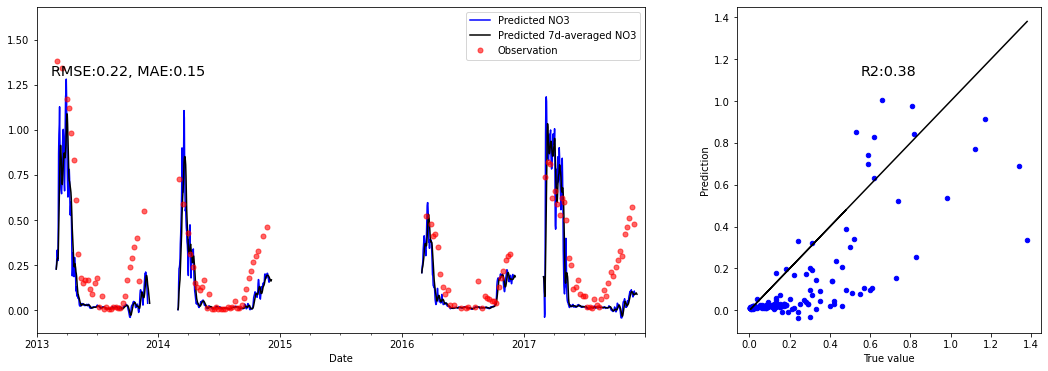

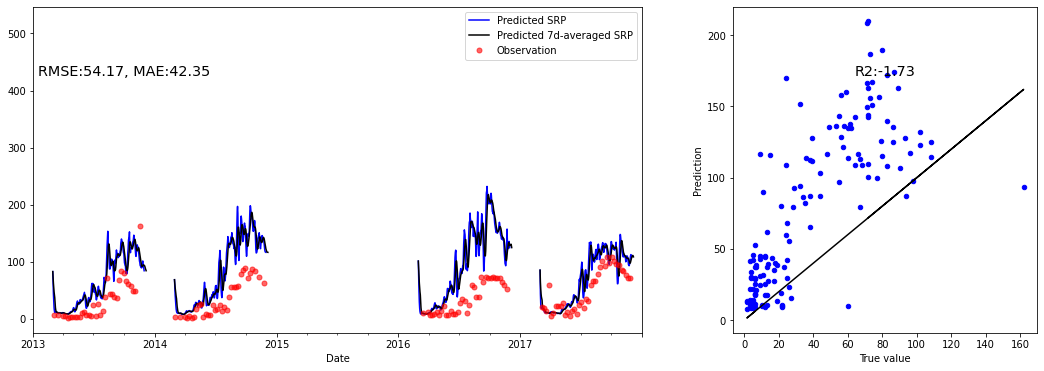

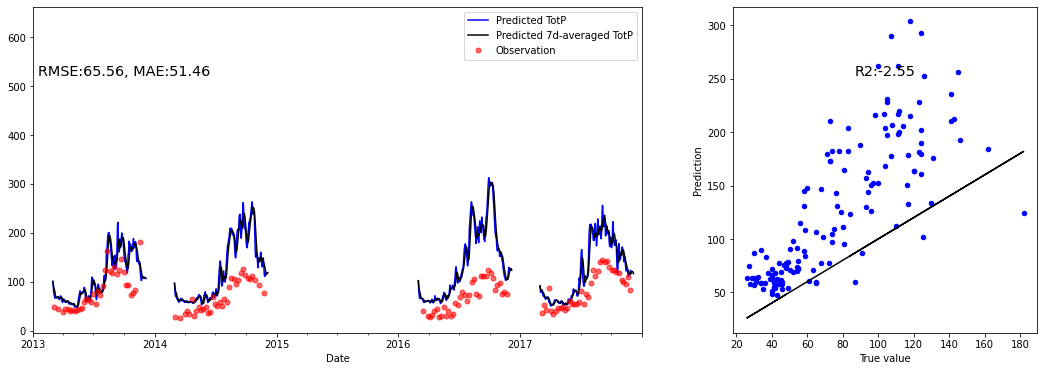

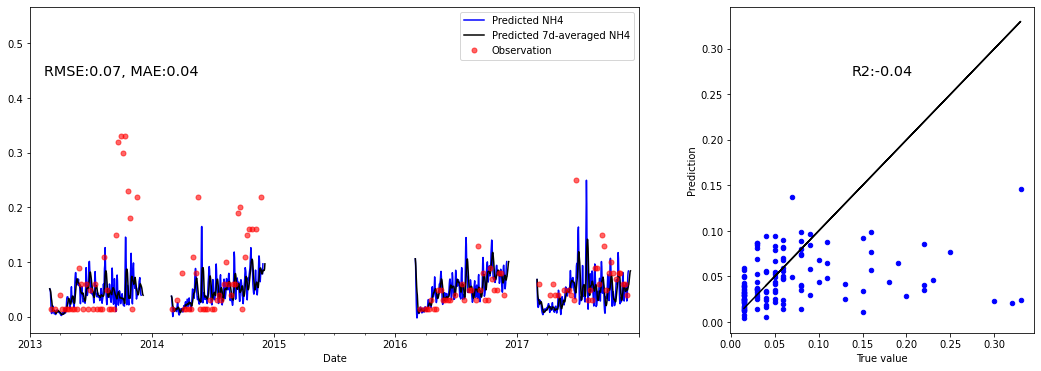

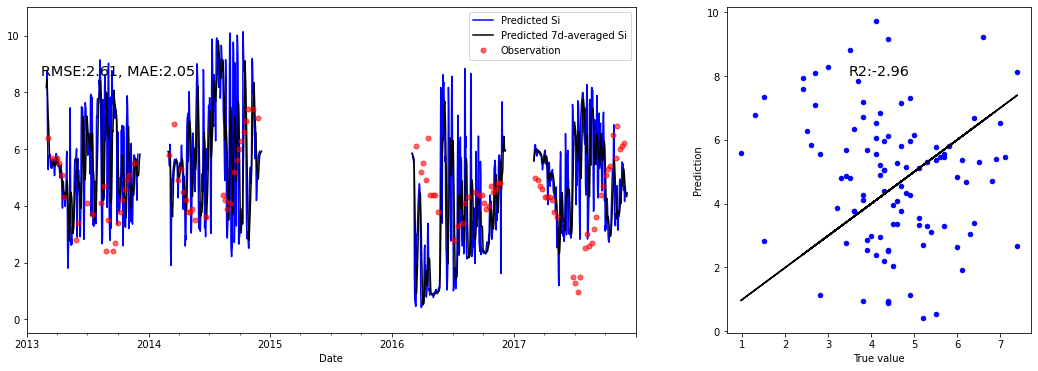

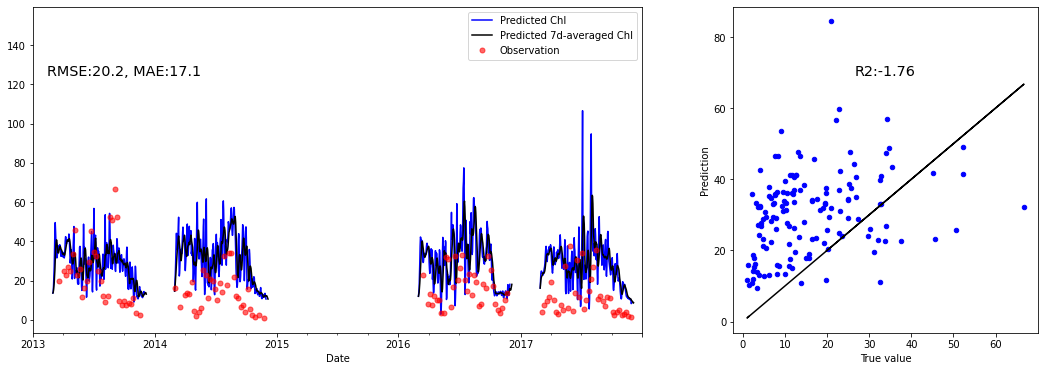

In [122]:
for k in range(1,n_Nut+1):
    nutrient_compare = Nut_memory[(Nut_memory['Date']>test_time[0])&(Nut_memory['Date']<test_time[1])][['Date',Nut_f[k]]].merge(all_df[['Date',Nut_f[k]]],how = 'inner',on = 'Date').dropna()
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Nut_memory,how = 'left',on = 'Date')
 
    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared=False)
    MAE = mean_absolute_error(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot time-series comparison
    f1,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =Nut_f[k],c = 'b',ax = ax2[0],label = 'Predicted '+Nut_f[k])
    Lake_Nut_gap[Nut_f[k]] = Lake_Nut_gap[Nut_f[k]].rolling(7,min_periods = 1).mean()
    Lake_Nut_gap.plot(x = 'Date',y =Nut_f[k],c = 'k',ax = ax2[0],
                      label = 'Predicted 7d-averaged '+Nut_f[k])
    all_df[['Date',Nut_f[k]]].plot(x = 'Date',y =Nut_f[k],style = 'ro',ms = 5,alpha = 0.6,ax = ax2[0],
                               label = 'Observation')
    ax2[0].text(0.15, 0.8, 'RMSE:{}, MAE:{}'.format(round(RMSE,2),round(MAE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')

    ax2[0].set_xlim((test_time[0],test_time[1]))
    #ax2[0].set_ylim(Lake_Nut[Nut[k]].min(),Lake_Nut[Nut[k]].max())

    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    f1.savefig(lakename+'_LSTM_'+Nut_f[k]+'.png',dpi = 500)